In [24]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage.io import imread_collection, ImageCollection
from skimage import transform
from skimage import img_as_int
from skimage import data
from skimage.transform import swirl
import skimage as skimage
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
import alpenglow.stitching2 as ast2
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack
from alpenglow.stitching2 import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack

In [25]:
import configparser
import os.path as op

In [26]:
import numpy as np
import cottoncandy as cc

In [4]:
file_list = ['/skin_draq5_nhs488/draq5/im_%06d_%06d.tif'%(s, i) for s in range(3) for i in range(1, 1801) ]

In [27]:
CP = configparser.ConfigParser()
CP.read_file(open(op.join(op.expanduser('~'), '.aws', 'credentials')))
CP.sections()
ak = CP.get('default', 'AWS_ACCESS_KEY_ID')
sk = CP.get('default', 'AWS_SECRET_ACCESS_KEY')

In [28]:
cci = cc.get_interface('raw-alpenglow', 
                       ACCESS_KEY=ak, 
                       SECRET_KEY=sk,
                       endpoint_url='https://s3.amazonaws.com',
                       verbose=False)

draq5 = af.s3_to_array('/skin_draq5_nhs488/draq5/im_000002_000100.tif', cci)
nhs488 = af.s3_to_array('/skin_draq5_nhs488/nhs488/im_000002_000100.tif', cci)

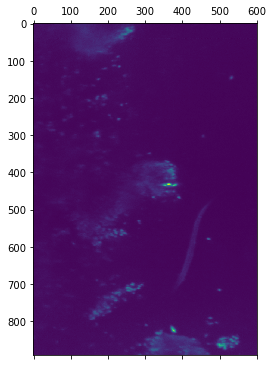

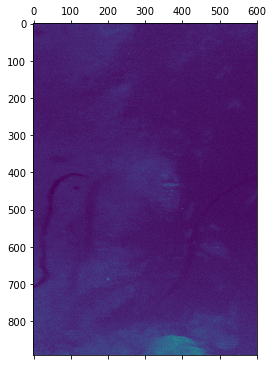

In [29]:
plt.matshow(draq5[:,1800:2400])
plt.matshow(nhs488[:,1800:2400])

In [31]:
#constants
bkg_eosin=1000;
bkg_draq5=350;
k_eosin=0.011;
k_draq5=0.038;
voff1=10;
hoff1=-50;
beta1=0.860;
beta2=0.05;
beta3=1;
beta4=1;
beta5=0.300;
beta6=0.544;

In [37]:
ind=np.where(nhs488>50);
m1=np.mean(nhs488[ind])*8;
nhs488=nhs488*(255/m1);

In [ ]:
ind=find(draq5>500);
m2=mean(draq5(ind))*8;
draq5=draq5*(65535/m2)*(255/65535);

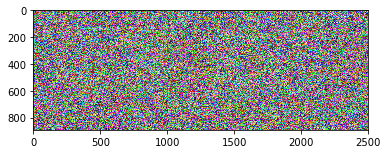

In [40]:
rgbArray = np.zeros((892,2500,3))
rgbArray[..., 0] = np.exp(-beta2*nhs488*k_eosin)*255
rgbArray[..., 1] = np.exp(-beta4*nhs488*k_eosin)*255
rgbArray[..., 2] = np.exp(-beta6*nhs488*k_eosin)*255
eosin = rgbArray
plt.imshow(eosin)

In [15]:
def _tile_plot(imgs, titles, **kwargs):
    """
    Helper function
    """
    # Create a new figure and plot the three images
    fig, ax = plt.subplots(1, len(imgs))
    for ii, a in enumerate(ax):
        a.set_axis_off()
        a.imshow(imgs[ii], **kwargs)
        a.set_title(titles[ii])

    return fig

In [13]:
def overlay_images(img0, img1, title0='', title_mid='', title1='', fname=None):
    r""" Plot two images one on top of the other using red and green channels.
    Creates a figure containing three images: the first image to the left
    plotted on the red channel of a color image, the second to the right
    plotted on the green channel of a color image and the two given images on
    top of each other using the red channel for the first image and the green
    channel for the second one. It is assumed that both images have the same
    shape. The intended use of this function is to visually assess the quality
    of a registration result.
    Parameters
    ----------
    img0 : array, shape(R, C)
        the image to be plotted on the red channel, to the left of the figure
    img1 : array, shape(R, C)
        the image to be plotted on the green channel, to the right of the
        figure
    title0 : string (optional)
        the title to be written on top of the image to the left. By default, no
        title is displayed.
    title_mid : string (optional)
        the title to be written on top of the middle image. By default, no
        title is displayed.
    title1 : string (optional)
        the title to be written on top of the image to the right. By default,
        no title is displayed.
    fname : string (optional)
        the file name to write the resulting figure. If None (default), the
        image is not saved.
    """
    # Normalize the input images to [0,255]
    img0 = 255 * ((img0 - img0.min()) / (img0.max() - img0.min()))
    img1 = 255 * ((img1 - img1.min()) / (img1.max() - img1.min()))

    # Create the color images
    img0_red = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)
    img1_green = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)
    overlay = np.zeros(shape=(img0.shape) + (3,), dtype=np.uint8)

    # Copy the normalized intensities into the appropriate channels of the
    # color images
    img0_red[..., 0] = img0
    img1_green[..., 1] = img1
    overlay[..., 0] = img0
    overlay[..., 1] = img1

    fig = _tile_plot([img0_red, overlay, img1_green],
                     [title0, title_mid, title1])

    # If a file name was given, save the figure
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')

    return fig

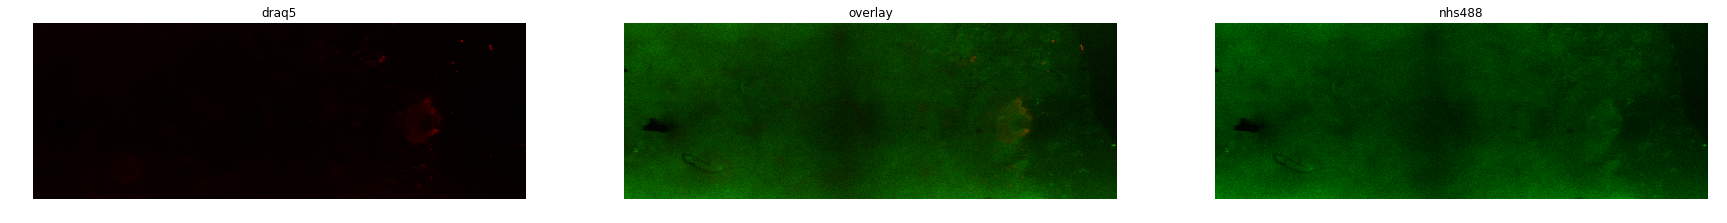

In [20]:
fig = overlay_images(draq5, nhs488, title0='draq5', title_mid='overlay', title1='nhs488', fname=None)
fig.set_size_inches(30,30)